<a href="https://colab.research.google.com/github/sajad95/Heat/blob/main/FastCodeImpactofweatherXGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Let's do it :)

# installing librarires
!pip install xgboost
!pip install pandas --quiet
!pip install scikit-learn --upgrade --quiet

# importing libraries
import pandas as pd
import xgboost as xgb
from sklearn.svm import SVR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from google.colab import drive
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
# mounting google drive and uploading the data
drive.mount('/content/saj')
raw_df = pd.read_csv('/content/saj/MyDrive/Kavgic/AllFeaturesInAllyears2.csv')
TMY_df = pd.read_csv('/content/saj/MyDrive/Kavgic/TW.csv')

#remove extra spaces using strip
raw_df['Direct Normal Radiation']=pd.to_numeric(raw_df['Direct Normal Radiation'].astype(str).str.strip())
raw_df['Diffuse Horizontal Radiation']=pd.to_numeric(raw_df['Diffuse Horizontal Radiation'].astype(str).str.strip())

TMY_df['Direct Normal Radiation']=pd.to_numeric(TMY_df['Direct Normal Radiation'].astype(str).str.strip())
TMY_df['Diffuse Horizontal Radiation']=pd.to_numeric(TMY_df['Diffuse Horizontal Radiation'].astype(str).str.strip())
#removing extra spaces in name of the columns 
raw_df.columns = [col.strip() for col in raw_df.columns]
TMY_df.columns = [col.strip() for col in TMY_df.columns]

#removing every rows that has nan values 
raw_df.dropna(subset=['Dry Bulb Temperature','Wind Direction','Direct Normal Radiation','Diffuse Horizontal Radiation'], inplace =True)
TMY_df.dropna(subset=['Dry Bulb Temperature','Wind Direction','Direct Normal Radiation','Diffuse Horizontal Radiation'], inplace =True)

Drive already mounted at /content/saj; to attempt to forcibly remount, call drive.mount("/content/saj", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Heating ( Electricity)

In [52]:
raw_df.columns

Index(['Date', 'Time', 'Dry Bulb Temperature', 'Dew Point Temperature',
       'Relative Humidity', 'Atmospheric Pressure',
       'Extraterrestrial Horizontal Radiation',
       'Extraterrestrial Direct Normal Radiation',
       'Horizontal Infrared Radiation Intensity from Sky',
       'Global Horizontal Radiation', 'Direct Normal Radiation',
       'Diffuse Horizontal Radiation', 'Global Horizontal Illuminance',
       'Direct Normal Illuminance', 'Diffuse Horizontal Illuminance',
       'Zenith Luminance', 'Wind Direction', 'Wind Speed', 'Total Sky Cover',
       'Opaque Sky Cover', 'Visibility', 'Ceiling Height',
       'Present Weather Observation', 'Precipitable Water',
       'Aerosol Optical Depth', 'Snow Depth', 'Days Since Last Snow', 'Albedo',
       'Liquid Precipitation Depth', 'Liquid Precipitation Quantity',
       'People Total Heating Energy',
       'Total Zone Infiltration Sensible Heat Gain Energy',
       'Averge Zones temp', 'ATTIC:Zone Air Temperature', 'LightsE

Get the index of coloumns

In [53]:
raw_df.columns.get_loc('GasHVAC')

37

In [54]:
#Remving columns by their index
## Actua weather data file 
raw_df3=raw_df.drop(raw_df.columns[[6,7,15,16,20,21,22,23,24,25,26,27,28,29,34,35,37,38]], axis=1)
## Typical weather data file 
TMY_df3=TMY_df.drop(TMY_df.columns[[6,7,15,16,20,21,22,23,24,25,26,27,28,29,34,35,37,38]], axis=1)

In [55]:
pd.set_option('max_columns', None)
raw_df3.head(1)

,Date,Time,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Pressure,Horizontal Infrared Radiation Intensity from Sky,Global Horizontal Radiation,Direct Normal Radiation,Diffuse Horizontal Radiation,Global Horizontal Illuminance,Direct Normal Illuminance,Diffuse Horizontal Illuminance,Wind Speed,Total Sky Cover,Opaque Sky Cover,People Total Heating Energy,Total Zone Infiltration Sensible Heat Gain Energy,Averge Zones temp,ATTIC:Zone Air Temperature,Heating
0,1/1/2010,1:00,-21.6,-25.4,71.0,100230.0,177.240384,0,0.0,0.0,0,0,0,9.0,0,8,0.0,4476693.0,13.00748,-28.1504,900000.0


In [56]:
raw_df3.insert(0, 'Heating', raw_df3.pop('Heating'))
TMY_df3.insert(0, 'Heating', TMY_df3.pop('Heating'))

##Removing Outliers

##Outliers 
https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/

Draw a boxplot for each numeric variable in a DataFrame
https://seaborn.pydata.org/examples/horizontal_boxplot.html

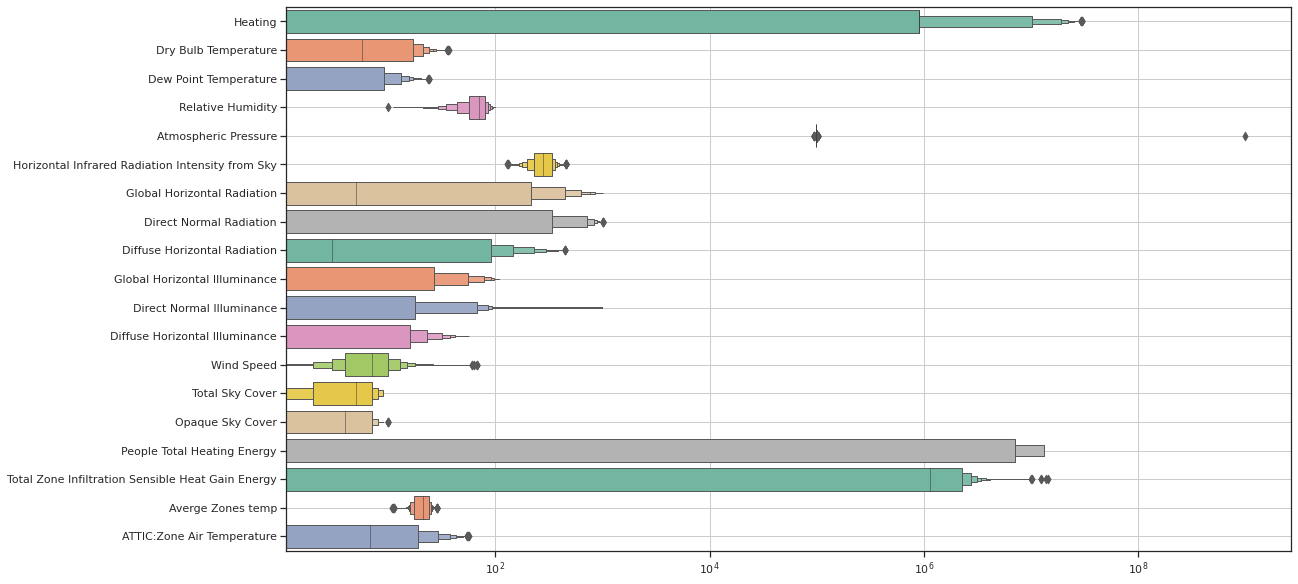

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(18, 10))
ax.set_xscale("log")
ax = sns.boxenplot(data=raw_df3, orient="h", palette="Set2", linewidth=1)
ax.xaxis.grid(True)
ax.yaxis.grid(True)
#boxplot If you used it, you should remove scale = 'linear'
#boxenplot if you used it, you can use scale = 'linear'

Automatic Outlier Detection

In [58]:
new_raw_df3 = raw_df3.drop(['Date','Time'], axis=1)

In [59]:
from sklearn.ensemble import IsolationForest

In [60]:
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.2)
yhat = iso.fit_predict(new_raw_df3)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [61]:
mask = yhat != -1

In [62]:
# Filtering a series using a boolean arrays
from itertools import compress
Filtered_new_raw_df3 = list(compress(new_raw_df3, mask))

In [63]:
# Filtering a dataframe using a boolean arrays
newmask= pd.Series(mask)
new_raw_df3 = new_raw_df3[newmask.values]

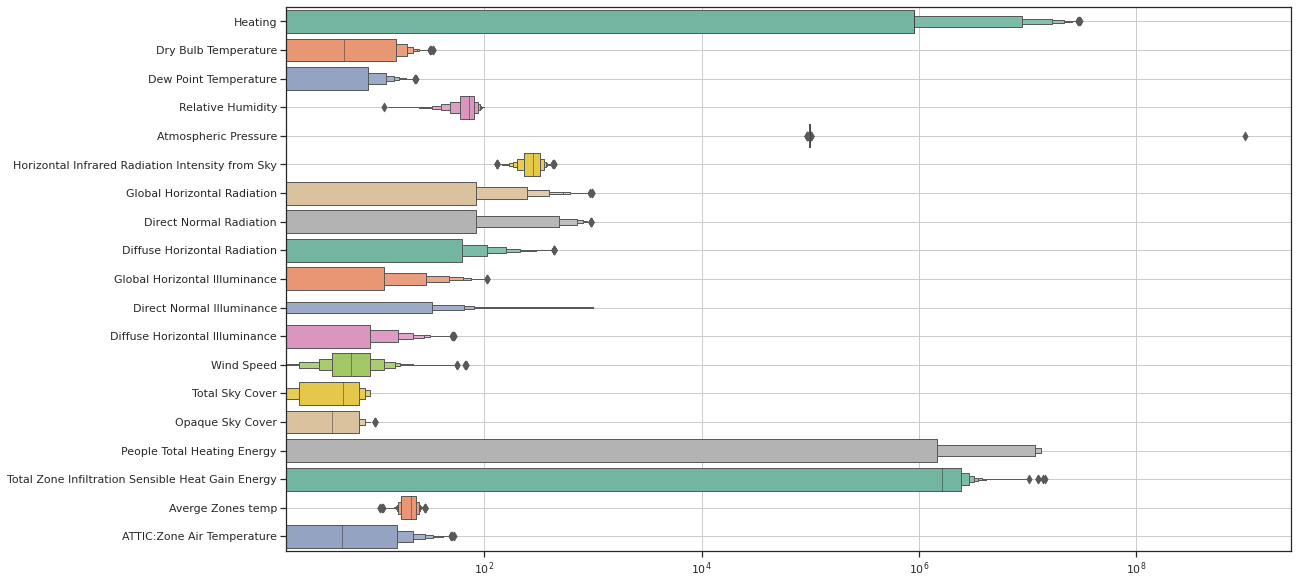

In [65]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(18, 10))
ax.set_xscale("log")
ax = sns.boxenplot(data=new_raw_df3, orient="h", palette="Set2", linewidth=1)
ax.xaxis.grid(True)
ax.yaxis.grid(True)
#boxplot If you used it, you should remove scale = 'linear'
#boxenplot if you used it, you can use scale = 'linear'

Removing Outliers Manually

##Input nad Target

In [ ]:
##spliting data  
year = pd.to_datetime(raw_df3.Date).dt.year
train_df = raw_df3[year < 2017]
val_df = raw_df3[year == 2017]
test_df = raw_df3[ year == 2019]

In [ ]:
## specifying input and target in  Actua weather data file
input_cols = (train_df.columns)[2:]
target_col = 'Heating'
## specifying input and target in Typical weather data file
input_cols_TMY2 = (TMY_df3.columns)[2:]
target_col_TMY2 = 'Heating'

In [ ]:
## Creating a copy from data to keep the main data intact
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
test_inputs = test_df[input_cols].copy()
test_inputs_sc = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()
train_inputs = train_df[input_cols].copy()
train_inputs_sc = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
test_inputs_TMY = TMY_df3[input_cols_TMY2].copy()
test_inputs_TMY_sc = TMY_df3[input_cols_TMY2].copy()
test_targets_TMY = TMY_df3[target_col_TMY2].copy()

## developing model

model = SVR(kernel='rbf', C=100, gamma=0.2)

model1 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.5, learning_rate = 0.2,
                max_depth = 10,reg_lambda=10, alpha = 6, n_estimators = 100)

## Normalizing

In [ ]:
scaler1=MinMaxScaler()
scaler2=StandardScaler()
#test_inputs[1:]  = scaler1.fit_transform(test_inputs[1:])
#type(train_inputs['Atmospheric Pressure'])


https://www.geeksforgeeks.org/pandas-concat-function-in-python/

Scaling Data Frame
https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

In [ ]:
train_inputs.head(1)

,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Pressure,Horizontal Infrared Radiation Intensity from Sky,Global Horizontal Radiation,Direct Normal Radiation,Diffuse Horizontal Radiation,Global Horizontal Illuminance,Direct Normal Illuminance,Diffuse Horizontal Illuminance,Wind Speed,Total Sky Cover,Opaque Sky Cover,People Total Heating Energy,Total Zone Infiltration Sensible Heat Gain Energy,Averge Zones temp,ATTIC:Zone Air Temperature
0,-21.6,-25.4,71.0,100230.0,177.240384,0,0.0,0.0,0,0,0,9.0,0,8,0.0,4476693.0,13.00748,-28.1504


In [ ]:
train_inputs_sc[['Dry Bulb Temperature', 'Dew Point Temperature','Relative Humidity','Atmospheric Pressure','Horizontal Infrared Radiation Intensity from Sky','Global Horizontal Radiation','Direct Normal Radiation','Diffuse Horizontal Radiation','Global Horizontal Illuminance','Direct Normal Illuminance','Diffuse Horizontal Illuminance','Wind Speed','Total Sky Cover','Opaque Sky Cover','People Total Heating Energy','Total Zone Infiltration Sensible Heat Gain Energy','Averge Zones temp','ATTIC:Zone Air Temperature']] = scaler1.fit_transform(train_inputs_sc[['Dry Bulb Temperature', 'Dew Point Temperature','Relative Humidity','Atmospheric Pressure','Horizontal Infrared Radiation Intensity from Sky','Global Horizontal Radiation','Direct Normal Radiation','Diffuse Horizontal Radiation','Global Horizontal Illuminance','Direct Normal Illuminance','Diffuse Horizontal Illuminance','Wind Speed','Total Sky Cover','Opaque Sky Cover','People Total Heating Energy','Total Zone Infiltration Sensible Heat Gain Energy','Averge Zones temp','ATTIC:Zone Air Temperature']])
test_inputs_sc[['Dry Bulb Temperature', 'Dew Point Temperature','Relative Humidity','Atmospheric Pressure','Horizontal Infrared Radiation Intensity from Sky','Global Horizontal Radiation','Direct Normal Radiation','Diffuse Horizontal Radiation','Global Horizontal Illuminance','Direct Normal Illuminance','Diffuse Horizontal Illuminance','Wind Speed','Total Sky Cover','Opaque Sky Cover','People Total Heating Energy','Total Zone Infiltration Sensible Heat Gain Energy','Averge Zones temp','ATTIC:Zone Air Temperature']] = scaler1.fit_transform(test_inputs_sc[['Dry Bulb Temperature', 'Dew Point Temperature','Relative Humidity','Atmospheric Pressure','Horizontal Infrared Radiation Intensity from Sky','Global Horizontal Radiation','Direct Normal Radiation','Diffuse Horizontal Radiation','Global Horizontal Illuminance','Direct Normal Illuminance','Diffuse Horizontal Illuminance','Wind Speed','Total Sky Cover','Opaque Sky Cover','People Total Heating Energy','Total Zone Infiltration Sensible Heat Gain Energy','Averge Zones temp','ATTIC:Zone Air Temperature']])
test_inputs_TMY_sc[['Dry Bulb Temperature', 'Dew Point Temperature','Relative Humidity','Atmospheric Pressure','Horizontal Infrared Radiation Intensity from Sky','Global Horizontal Radiation','Direct Normal Radiation','Diffuse Horizontal Radiation','Global Horizontal Illuminance','Direct Normal Illuminance','Diffuse Horizontal Illuminance','Wind Speed','Total Sky Cover','Opaque Sky Cover','People Total Heating Energy','Total Zone Infiltration Sensible Heat Gain Energy','Averge Zones temp','ATTIC:Zone Air Temperature']] = scaler1.fit_transform(test_inputs_TMY_sc[['Dry Bulb Temperature', 'Dew Point Temperature','Relative Humidity','Atmospheric Pressure','Horizontal Infrared Radiation Intensity from Sky','Global Horizontal Radiation','Direct Normal Radiation','Diffuse Horizontal Radiation','Global Horizontal Illuminance','Direct Normal Illuminance','Diffuse Horizontal Illuminance','Wind Speed','Total Sky Cover','Opaque Sky Cover','People Total Heating Energy','Total Zone Infiltration Sensible Heat Gain Energy','Averge Zones temp','ATTIC:Zone Air Temperature']])

In [ ]:
train_inputs_sc.head(1)

,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Pressure,Horizontal Infrared Radiation Intensity from Sky,Global Horizontal Radiation,Direct Normal Radiation,Diffuse Horizontal Radiation,Global Horizontal Illuminance,Direct Normal Illuminance,Diffuse Horizontal Illuminance,Wind Speed,Total Sky Cover,Opaque Sky Cover,People Total Heating Energy,Total Zone Infiltration Sensible Heat Gain Energy,Averge Zones temp,ATTIC:Zone Air Temperature
0,0.154185,0.186579,0.677778,0.000006,0.139013,0.0,0.0,0.0,0.0,0.0,0.0,0.132353,0.0,0.8,0.0,0.308811,0.116772,0.055142


Scaling series

In [ ]:
train_targets_sc=np.array(train_targets).reshape(-1,1);
test_targets_sc=np.array(test_targets).reshape(-1,1);
test_targets_TMY_sc=np.array(test_targets_TMY).reshape(-1,1);

In [ ]:
train_targets_sc = scaler1.fit_transform(train_targets_sc)
test_targets_sc = scaler1.fit_transform(test_targets_sc)
test_targets_TMY_sc = scaler1.fit_transform(test_targets_TMY_sc)

In [ ]:
model1.fit(train_inputs_sc, train_targets_sc)

[17:39:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=6, colsample_bytree=0.5, learning_rate=0.2, max_depth=10,
             reg_lambda=10)

In [ ]:
preds3= model1.predict(test_inputs_sc)

In [ ]:
preds4 = model1.predict(test_inputs_TMY_sc)

In [ ]:
AW_pre = pd.DataFrame(preds3 , columns =['Predicted using data of 2019'] )
TMY_pre = pd.DataFrame(preds4 , columns =['Predicted using data of TW'] )
test_targets_sc = pd.DataFrame(test_targets_sc , columns =['Ground Truth Values of 2019'] )

Predicting energy in 2019 using the data of 2019 itself and comparing with real values in 2019

In [ ]:
R2_score1=r2_score(AW_pre, test_targets_sc)
print(R2_score1)
print('%.2f' % R2_score1)

0.9591702507391862
0.96


In [ ]:
A = scaler1.inverse_transform(test_targets_sc)
A.shape

(8760, 1)

In [ ]:
AW_pre

,Predicted using data of 2019
0,0.029604
1,0.028490
2,0.030033
3,0.029573
4,0.029481
...,...
8755,0.391301
8756,0.417574
8757,0.407853
8758,0.415797


In [ ]:
Prediction_after_applying_inverse = np.sort(AW_pre, axis = 0)
Prediction_after_applying_inverse

array([[ -895345.94],
       [ -743696.44],
       [ -739905.7 ],
       ...,
       [25288146.  ],
       [25648888.  ],
       [25655808.  ]], dtype=float32)

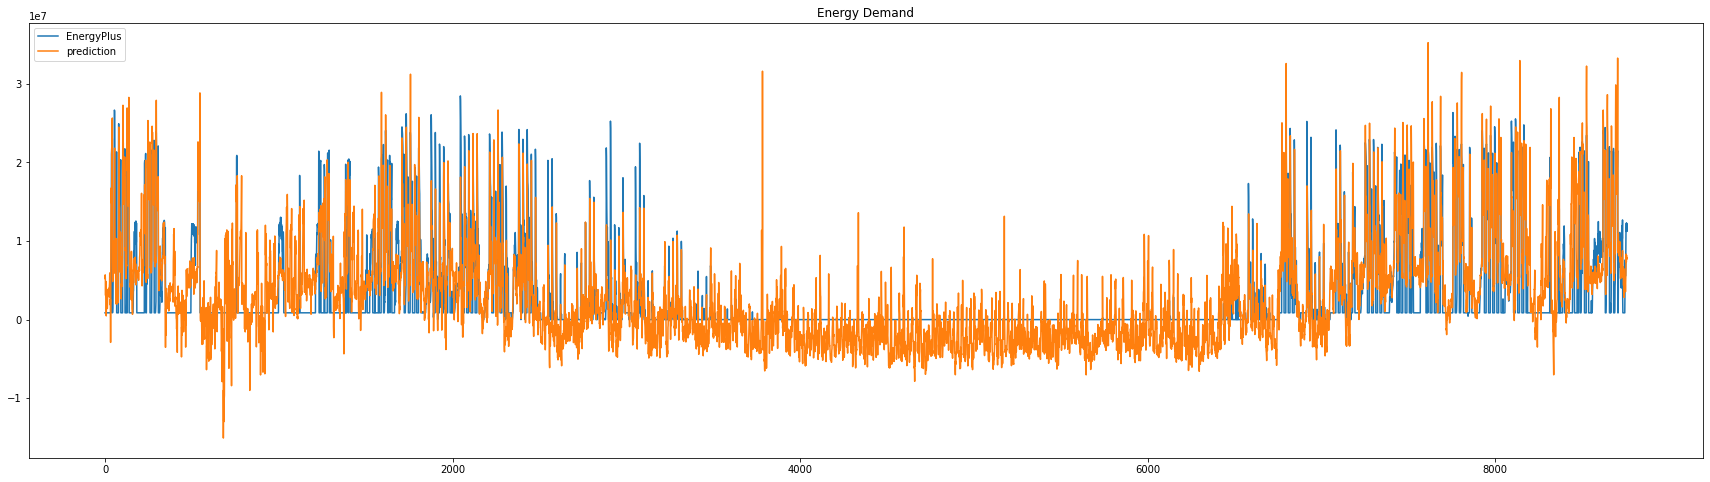

In [ ]:
plt.figure(figsize=(30,8));
x_ax = range ( len(test_targets_sc))
plt.plot(x_ax,A, label ="EnergyPlus")
plt.plot (x_ax,B, label = "prediction")
plt.title("Energy Demand")
plt.legend()
plt.show()

## No Normalization + Removing Outliers

In [ ]:
model1.fit(train_inputs_sc, train_targets_sc)

In [ ]:
preds3= model1.predict(test_inputs)

In [ ]:
preds4 = model1.predict(test_inputs)

In [ ]:
# No scaling
#C=pd.DataFrame(test_df[target_col]) 
#C.reset_index(inplace = True)
#C.drop('index', axis=1, inplace=True)

In [ ]:
#Scaled C
#C_sc=pd.DataFrame(test_df[target_col]) 
#C_sc.reset_index(inplace = True)
#C_sc.drop('index', axis=1, inplace=True)

In [ ]:
Heating = pd.DataFrame(preds3, columns =['predicted for Heating 2019 using data belobged to 2019'])
Heating[' Heating Real Values'] = C
#raw_df.to_csv('Heating.csv')
Heating

In [ ]:
plt.figure(figsize=(30,8));
x_ax = range ( len(preds3))
plt.plot(x_ax,preds3, label ="predicted 2019")
#plt.plot(x_ax,preds3, label = "AC")
plt.plot(x_ax,C, label = "Real values 2019")
plt.title("Comparison Heating")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(6.5,5.3));
plt.plot(C,preds3,'bo');
plt.plot([0,3e7],[0,3e7],'-',color=[0.1,0.1,0.1,0.5],linewidth=1)

Lets find Accuracy of the model in mins and maxes

In doe file the threshold of heating is 15 degC

Max :

In [ ]:
Max_Min = test_targets.to_frame(name ='Heating')

In [ ]:
test_inputs.sort_values(by="Dry Bulb Temperature")

In [ ]:
## Extract their index
# saving indexes in a new column named index
index = test_inputs.index
condition = test_inputs['Dry Bulb Temperature']  <-30 
indices = index[condition]
indices_list = indices.tolist()
print(indices_list)

In [ ]:
Max_input = test_inputs.loc[[79300, 79301, 79302, 79303, 79304, 79305, 79516, 79517, 79518, 79519, 79520, 79521, 79522, 79523, 79524, 79525, 79526, 79527, 79528, 79529, 79530, 79531, 79532, 79533, 79534, 79535, 79536, 79537, 79538, 79539, 79540, 79541, 79542, 79543, 79544, 79545, 79546, 79547, 79548, 79549, 79554, 79555, 79556, 79557, 79558, 79559, 79560, 79561, 79562, 79563, 79564, 79565, 79566, 79567, 79568],:]

In [ ]:
Max_Target= Max_Min.loc[[79300, 79301, 79302, 79303, 79304, 79305, 79516, 79517, 79518, 79519, 79520, 79521, 79522, 79523, 79524, 79525, 79526, 79527, 79528, 79529, 79530, 79531, 79532, 79533, 79534, 79535, 79536, 79537, 79538, 79539, 79540, 79541, 79542, 79543, 79544, 79545, 79546, 79547, 79548, 79549, 79554, 79555, 79556, 79557, 79558, 79559, 79560, 79561, 79562, 79563, 79564, 79565, 79566, 79567, 79568],:]

In [ ]:
Max_Target.head(5)

Fitting the model on Max

In [ ]:
predsMax = model.predict(Max_input)

Reset the index of max_target

In [ ]:
Max_Target=pd.DataFrame(Max_Target['Heating']) 
Max_Target.reset_index(inplace = True)
Max_Target.drop('index', axis=1, inplace=True)

In [ ]:
MaxHeating = pd.DataFrame(predsMax, columns =['predicted Max values for heating '])
MaxHeating[' Max Heating Real Values'] = Max_Target
MaxHeating.head(10)

In [ ]:
plt.figure(figsize=(30,8));
x_ax = range ( len(predsMax))
plt.plot(x_ax,predsMax, label ="predicted  Max values for 2019")
#plt.plot(x_ax,preds3, label = "AC")
plt.plot(x_ax,Max_Target, label = "Real Max values for 2019")
plt.title("Comparison Heating")
plt.legend()
plt.show()

Min:

In [ ]:
## Extract their index
# saving indexes in a new column named index
index = test_inputs.index
condition = test_inputs['Dry Bulb Temperature']  >30
indices = index[condition]
indices_list = indices.tolist()
print(indices_list)

In [ ]:
Min_input = test_inputs.loc[[82433, 82619, 82620, 82621, 82622, 82623, 82624, 82625, 82626, 82627, 82628, 82629, 83129, 83172, 83173, 83174, 83175, 83176, 83177, 83513, 83514, 83943, 83944, 83945, 83946, 83965, 83966, 83967, 83968, 83988, 83989, 83990, 83991, 83992, 83993, 83994, 84014, 84015, 84016, 84017, 84018],:]

In [ ]:
Min_Target = Max_Min.loc[[82433, 82619, 82620, 82621, 82622, 82623, 82624, 82625, 82626, 82627, 82628, 82629, 83129, 83172, 83173, 83174, 83175, 83176, 83177, 83513, 83514, 83943, 83944, 83945, 83946, 83965, 83966, 83967, 83968, 83988, 83989, 83990, 83991, 83992, 83993, 83994, 84014, 84015, 84016, 84017, 84018],:]

In [ ]:
predsMin = model.predict(Min_input)

In [ ]:
Min_Target=pd.DataFrame(Min_Target['Heating']) 
Min_Target.reset_index(inplace = True)
Min_Target.drop('index', axis=1, inplace=True)

In [ ]:
MinHeating = pd.DataFrame(predsMin, columns =['predicted Min values for heating '])
MinHeating[' Min Heating Real Values'] = Min_Target
MinHeating.head(10)

In [ ]:
plt.figure(figsize=(30,8));

x_ax = range ( len(predsMin))
plt.plot(x_ax,predsMin, label ="predicted  Min values for 2019")
#plt.plot(x_ax,preds3, label = "AC")
plt.plot(x_ax,Min_Target, label = "Real Min values for 2019")
plt.title("Comparison Heating")
plt.legend()
plt.show()

Detect and Remove the Outliers 

In [ ]:
Heating

In [ ]:
import seaborn as sns
sns.boxplot(Heating[' Heating Real Values'])

In [ ]:
# Position of the Outlier of real value
print(np.where(Heating[' Heating Real Values']>110000))

In [ ]:
# Position of the Outlier of predicted values
print(np.where(Heating['predicted for Heating 2019 using data belobged to 2019'] > 110000))

In [ ]:
# Scatter plot
fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(Heating[' Heating Real Values'],Heating['predicted for Heating 2019 using data belobged to 2019'])

# x-axis label
ax.set_xlabel('Heating Real Values')

# y-axis label
ax.set_ylabel('predicted for Heating 2019 using data belobged to 2019')
plt.show()


In [ ]:
# Position of the Outlier
print(np.where((Heating[' Heating Real Values']>110000) & (Heating['predicted for Heating 2019 using data belobged to 2019']>1200)))


Z- Score is also called a standard score. This value/score helps to understand that how far is the data point from the mean. And after setting up a threshold value one can utilize z score values of data points to define the outliers.

automatic outlier detection
https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/

Each method will be defined, then fit on the training dataset. The fit model will then predict which examples in the training dataset are outliers and which are not (so-called inliers). The outliers will then be removed from the training dataset, then the model will be fit on the remaining examples and evaluated on the entire test dataset.
It would be invalid to fit the outlier detection method on the entire training dataset as this would result in data leakage. That is, the model would have access to data (or information about the data) in the test set not used to train the model. This may result in an optimistic estimate of model performance.
We could attempt to detect outliers on “new data” such as the test set prior to making a prediction, but then what do we do if outliers are detected?

Isolation Forest, or iForest for short, is a tree-based anomaly detection algorithm: 
It is based on modeling the normal data in such a way as to isolate anomalies that are both few in number and different in the feature space.

Perhaps the most important hyperparameter in the model is the “contamination” argument, which is used to help estimate the number of outliers in the dataset. This is a value between 0.0 and 0.5 and by default is set to 0.1

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.02)
yhat = iso.fit_predict(train_inputs)

In [ ]:
mask = yhat != -1


In [ ]:
# Filtering a series using a boolean arrays
from itertools import compress
Filtered_Trian_Target = list(compress(train_targets, mask))
Filtered_Trian_Targets = pd.DataFrame(Filtered_Trian_Target, columns =['Heating'])

In [ ]:
# Filtering a dataframe using a boolean arrays
newmask= pd.Series(mask)
Filtered_Trian_inputs = train_inputs[newmask.values]
print(Filtered_Trian_Targets.shape, Filtered_Trian_inputs.shape)

In [ ]:
# fitting model on filtered  data
model.fit(Filtered_Trian_inputs, Filtered_Trian_Targets)

In [ ]:
preds3 = model.predict(test_inputs)
preds4 = model.predict(test_inputs_TMY)

In [ ]:
R2_score1=r2_score(test_targets, preds3)
print(R2_score1)
print('%.2f' % R2_score1)

In [ ]:
Heatingnew = pd.DataFrame(preds3, columns =['predicted for Heating 2019 using data belobged to 2019'])
Heatingnew[' Heating Real Values'] = C
#raw_df.to_csv('Heating.csv')
Heatingnew

In [ ]:
plt.figure(figsize=(30,8));

x_ax = range ( len(preds3))
plt.plot(x_ax,preds3, label ="predicted 2019")
#plt.plot(x_ax,preds3, label = "AC")
plt.plot(x_ax,C, label = "Real values 2019")
plt.title("Comparison Heating")
plt.legend()
plt.show()

In [ ]:
## Extract their index
# saving indexes in a new column named index
index = test_inputs.index
condition = test_inputs['Dry Bulb Temperature']  >30
indices = index[condition]
indices_list = indices.tolist()
print(indices_list)

In [ ]:
Min_input = test_inputs.loc[[82433, 82619, 82620, 82621, 82622, 82623, 82624, 82625, 82626, 82627, 82628, 82629, 83129, 83172, 83173, 83174, 83175, 83176, 83177, 83513, 83514, 83943, 83944, 83945, 83946, 83965, 83966, 83967, 83968, 83988, 83989, 83990, 83991, 83992, 83993, 83994, 84014, 84015, 84016, 84017, 84018],:]

In [ ]:
Min_Target = Max_Min.loc[[82433, 82619, 82620, 82621, 82622, 82623, 82624, 82625, 82626, 82627, 82628, 82629, 83129, 83172, 83173, 83174, 83175, 83176, 83177, 83513, 83514, 83943, 83944, 83945, 83946, 83965, 83966, 83967, 83968, 83988, 83989, 83990, 83991, 83992, 83993, 83994, 84014, 84015, 84016, 84017, 84018],:]

In [ ]:
predsMin = model.predict(Min_input)

In [ ]:
Min_Target=pd.DataFrame(Min_Target['Heating']) 
Min_Target.reset_index(inplace = True)
Min_Target.drop('index', axis=1, inplace=True)

In [ ]:
MinHeating = pd.DataFrame(predsMin, columns =['predicted Min values for heating '])
MinHeating[' Min Heating Real Values'] = Min_Target
MinHeating.head(10)

In [ ]:
plt.figure(figsize=(30,8));

x_ax = range ( len(predsMin))
plt.plot(x_ax,predsMin, label ="predicted  Min values for 2019")
#plt.plot(x_ax,preds3, label = "AC")
plt.plot(x_ax,Min_Target, label = "Real Min values for 2019")
plt.title("Comparison Heating")
plt.legend()
plt.show()

Predicting energy in 2019 using the Tyoical Weater data file :

Predicting energy in 2019 using the data of 2018 and comparing with real values in 2019

Predicting energy in 2019 using the data of TW and comparing with real values in 2019

In [ ]:
Heating = pd.DataFrame(preds3, columns =['predicted for Heating 2019 using TMY'])
#LightsElectricity['LightsElectricity via TMY'] = pd.DataFrame(preds4)
Heating[' Heating Real Values'] = C
raw_df.to_csv('Heating.csv')
Heating

In [ ]:
R2_score=r2_score(test_targets, preds3)
R2_score

In [ ]:
#Heating = pd.DataFrame(preds3, columns =['Heating 2019 '])
#Heating['Heating via TMY'] = pd.DataFrame(preds4)
#Heating.to_csv('Heating.csv')
#Heating

In [ ]:
plt.figure(figsize=(30,8));

x_ax = range ( len(preds4))
plt.plot(x_ax,preds4, label ="TMY")
#plt.plot(x_ax,preds3, label = "AC")
plt.plot(x_ax,C, label = "Real values 2019")
plt.title("Comparison Heating")
plt.legend()
plt.show()

In [ ]:
TMY_df3['Heating'][246]

In [ ]:
TMY_df3.loc[108:113]

In [ ]:
'''
raw_df3['Heating']= raw_df3['Heating'] + raw_df3['GasHVAC']
TMY_df3['Heating']= TMY_df3['Heating'] + TMY_df3['GasHVAC']
raw_df3['Heating']=raw_df3['Heating'] / 1000
TMY_df3['Heating']=TMY_df3['Heating'] / 1000
raw_df3 = raw_df3.drop('GasHVAC', 1)
TMY_df3 = TMY_df3.drop('GasHVAC', 1)
'''

In [ ]:
new_input = {'Dry Bulb Temperature': -24.5,
             'Dew Point Temperature': -28.4,
             'Relative Humidity': 70,
             'Atmospheric Pressure': 100480,
             'Extraterrestrial Horizontal Radiation': 0,
             'Extraterrestrial Direct Normal Radiation': 9999,
             'Horizontal Infrared Radiation Intensity from Sky': 166,
             'Global Horizontal Radiation': 0,
             'Direct Normal Radiation': 0,
             'Diffuse Horizontal Radiation': 0,
             'Global Horizontal Illuminance': 0,
             'Direct Normal Illuminance': 0,
             'Diffuse Horizontal Illuminance':0,
             'Zenith Luminance': 9999,
             'Wind Direction': 20,
             'Wind Speed': 6,
             'Total Sky Cover': 0,
             'Opaque Sky Cover': 8,
             'Visibility': 999,
             'Ceiling Height': 99990,
             'Present Weather Observation':9,
             'Precipitable Water': 0,
             'Aerosol Optical Depth':0 ,
             'Snow Depth' : 0,
             'Days Since Last Snow': 88,
             'Albedo' : 999,
             'Liquid Precipitation Depth' :999 ,
             'Liquid Precipitation Quantity' : 99,
             'People Total Heating Energy' :0 ,
             'Total Zone Infiltration Sensible Heat Gain Energy' : 893710,
             'Averge Zones temp': 14.66877,
             'ATTIC:Zone Air Temperature' : -24,
             
              }

In [ ]:
new_input_df = pd.DataFrame([new_input])
new_input_df.info()

In [ ]:
prediction = model.predict(new_input_df)
prediction

##Impact of weather data on energy demand


Goal is to find the best ways for predicting energy demand in 2019 and compare it with the doe model.
scenarios:
1.   **Training the model with data from 2011 to 2017**

*   predicting energy demand for 2019 when the TW is used ( used both TW files) and comapre it with 2018.  if I want to predict energy demand of 2019 wihout having any data, is it better to use TW or use weather data for previous years. If I want to use data belonged to previous years which year can prdict it better.
*   Effect of number of years on accuracy
*   Finding the accuarcy of model in max and min
*   See the accuaracy of the model on design days



2.   **Improving the accuracy of the model in mins and maxes**

*   Training the Heating and Cooling with deata belonged to cold and warm days
*   Training the data with two TW files
*   Testing the Data of a hot place for cooling
*   Removing columns maybe removin some columns decrease the r2 but it might increase the robutensess of model in predicting min and max
*   Effect of energy unit on result of prediction j vs kj vs Mj 












## predicting energy demand for 2019


* Goal is to find the accuary of he model
* How well TW can predict 2019 
* How well TW can predict 2018 



# Gas HVAC

In [ ]:
############# Light Electricity (j) ############# 
#electricity
raw_df1=raw_df.drop(raw_df.columns[[1,35,36,37,38]], axis=1)

## Typical weather data file ( all parts of energy consumption)
#electricity
TMY_df1=TMY_df.drop(TMY_df.columns[[1,35,36,37,38]], axis=1)

##spliting data  Actua weather data file Scen 2
year = pd.to_datetime(raw_df1.Date).dt.year

train_df = raw_df1[year < 2017]
val_df = raw_df1[year == 2017]
test_df = raw_df1[ year == 2019]

## specifying input an target in  Actua weather data file
input_cols = (train_df.columns)[1:-1]
target_col = 'LightsElectricity'
## specifying input an target in Typical weather data file
input_cols_TMY1 = (TMY_df1.columns)[1:-1]
target_col_TMY1 = 'LightsElectricity'

## Creating a copy from data to keep the main data intact
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
test_inputs_TMY = TMY_df1[input_cols_TMY1].copy()
test_targets_TMY = TMY_df1[target_col_TMY1].copy()

# developing model
model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1, learning_rate = 0.05,
                max_depth = 6, alpha = 10, n_estimators = 100)

#########specifying the metrics############
# fitting model on training data

model.fit(train_inputs, train_targets)
preds3 = model.predict(test_inputs)

model.fit(test_inputs_TMY, test_targets_TMY)
preds4 = model.predict(test_inputs_TMY)

In [ ]:
A =pd.DataFrame(test_df[target_col]) 

A.reset_index(inplace = True)
A.drop('index', axis=1, inplace=True)
A

In [ ]:
LightsElectricity = pd.DataFrame(preds4, columns =['predicted for LightsElectricity2019 using TMY'])
#LightsElectricity['LightsElectricity via TMY'] = pd.DataFrame(preds4)
LightsElectricity[' LightsElectricity Real Values'] = A 
raw_df.to_csv('LightsElectricity.csv')
LightsElectricity

In [ ]:
plt.figure(figsize=(15,8));
x_ax = range ( len(preds4))
plt.plot(x_ax,preds4, label ="Predicted for 2019 using TMY")
#plt.plot(x_ax,preds3, label = "Predicted for 2019 using data of 2019")
plt.plot(x_ax,A, label = "Real Value ")
plt.title("Comparison Lights Electricity")
plt.legend()
plt.show()


In [ ]:
############# Defining Scenarios ############# 
## Actua weather data file (all parts of energy consumption)

#cooling : [[34,36,37,38]]
raw_df2=raw_df.drop(raw_df.columns[[1,34,36,37,38]], axis=1)

#cooling : [[34,36,37,38]]
TMY_df2=TMY_df.drop(TMY_df.columns[[1,34,36,37,38]], axis=1)


##spliting data  Actua weather data file Scen 2
year = pd.to_datetime(raw_df2.Date).dt.year

train_df = raw_df2[year < 2017]
val_df = raw_df2[year == 2017]
test_df = raw_df2[ year == 2019]

## specifying input an target in  Actua weather data file
input_cols = (train_df.columns)[1:-1]
target_col = 'Cooling'
## specifying input an target in Typical weather data file
input_cols_TMY2 = (TMY_df2.columns)[1:-1]
target_col_TMY2 = 'Cooling'


## Creating a copy from data to keep the main data intact
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
test_inputs_TMY = TMY_df2[input_cols_TMY2].copy()
test_targets_TMY = TMY_df2[target_col_TMY2].copy()



# developing model
model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1, learning_rate = 0.05,
                max_depth = 6, alpha = 10, n_estimators = 100)

#########specifying the metrics############
# fitting model on training data
model.fit(train_inputs, train_targets)
preds = model.predict(train_inputs)


model.fit(train_inputs, train_targets)
preds3 = model.predict(test_inputs)

model.fit(test_inputs_TMY, test_targets_TMY)
preds4 = model.predict(test_inputs_TMY)

In [ ]:
B=pd.DataFrame(test_df[target_col]) 

B.reset_index(inplace = True)
B.drop('index', axis=1, inplace=True)
B

In [ ]:
cooling = pd.DataFrame(preds4, columns =['predicted for cooling 2019 using TMY'])
#LightsElectricity['LightsElectricity via TMY'] = pd.DataFrame(preds4)
cooling[' cooling Real Values'] = B 
raw_df.to_csv('cooling.csv')
cooling

In [ ]:
#cooling = pd.DataFrame(preds3, columns =['coolingvia2019 '])
#cooling['cooling via TMY'] = pd.DataFrame(preds4)
#cooling[' cooling Real Values'] = B
#raw_df.to_csv('cooling.csv')
#cooling

In [ ]:
#coolingvia2019 = pd.DataFrame(preds3, columns =['energy via 2019'])
#coolingvia2019['energy via TMY'] = pd.DataFrame(preds4)

In [ ]:
plt.figure(figsize=(15,8));
x_ax = range ( len(preds4))
plt.plot(x_ax,preds4, label ="TMY")
#plt.plot(x_ax,preds3, label = "AC")
plt.plot(x_ax,B, label = "Real values 2019")
plt.title("Comparison Cooling")
plt.legend()
plt.show()

In [ ]:
C=pd.DataFrame(test_df[target_col]) 

C.reset_index(inplace = True)
C.drop('index', axis=1, inplace=True)
C

In [ ]:
Heating = pd.DataFrame(preds4, columns =['predicted for Heating 2019 using TMY'])
#LightsElectricity['LightsElectricity via TMY'] = pd.DataFrame(preds4)
Heating[' Heating Real Values'] = C
raw_df.to_csv('Heating.csv')
Heating

In [ ]:
#Heating = pd.DataFrame(preds3, columns =['Heating 2019 '])
#Heating['Heating via TMY'] = pd.DataFrame(preds4)
#Heating.to_csv('Heating.csv')
#Heating

In [ ]:
plt.figure(figsize=(15,8));

x_ax = range ( len(preds4))
plt.plot(x_ax,preds4, label ="TMY")
#plt.plot(x_ax,preds3, label = "AC")
plt.plot(x_ax,C, label = "Real values 2019")
plt.title("Comparison Heating")
plt.legend()
plt.show()

In [ ]:
TMY_df3['Heating'][246]

In [ ]:
TMY_df3.loc[108:113]

In [ ]:
from IPython.display import display
with pd.option_context('display.max_rows', 50):
    display(TMY_df3[TMY_df3.Heating > 1000]);

In [ ]:
new_input = {'Dry Bulb Temperature': -24.5,
             'Dew Point Temperature': -28.4,
             'Relative Humidity': 70,
             'Atmospheric Pressure': 100480,
             'Extraterrestrial Horizontal Radiation': 0,
             'Extraterrestrial Direct Normal Radiation': 9999,
             'Horizontal Infrared Radiation Intensity from Sky': 166,
             'Global Horizontal Radiation': 0,
             'Direct Normal Radiation': 0,
             'Diffuse Horizontal Radiation': 0,
             'Global Horizontal Illuminance': 0,
             'Direct Normal Illuminance': 0,
             'Diffuse Horizontal Illuminance':0,
             'Zenith Luminance': 9999,
             'Wind Direction': 20,
             'Wind Speed': 6,
             'Total Sky Cover': 0,
             'Opaque Sky Cover': 8,
             'Visibility': 999,
             'Ceiling Height': 99990,
             'Present Weather Observation':9,
             'Precipitable Water': 0,
             'Aerosol Optical Depth':0 ,
             'Snow Depth' : 0,
             'Days Since Last Snow': 88,
             'Albedo' : 999,
             'Liquid Precipitation Depth' :999 ,
             'Liquid Precipitation Quantity' : 99,
             'People Total Heating Energy' :0 ,
             'Total Zone Infiltration Sensible Heat Gain Energy' : 893710,
             'Averge Zones temp': 14.66877,
             'ATTIC:Zone Air Temperature' : -24,
             
              }

In [ ]:
new_input_df = pd.DataFrame([new_input])
new_input_df.info()

In [ ]:
prediction = model.predict(new_input_df)
prediction